In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import gym_combrf
import matplotlib.pyplot as plt

import numpy as np

In [3]:
env = gym.make('combrf-v2')

In [4]:
obs = env.reset(np.exp(1j * 2 * np.pi * 0.6))
#print(obs)
#print(obs.shape)
print(env.ch_model)
print(env.tx_loc)
print(env.obs_space.sample())
print(env.rx_xcov)
print(env.sc_xyz)

uma-los
[[100   0   0]]
[0 0 7]
[-100    0  100]
[]


In [45]:
from Source.PER import PrioritizedReplayBuffer
from Source.env_manager import EnvManager
import torch
import random

BUFFER_SIZE = int(1e6)
BATCH_SIZE = 128
PER_ALPHA = 0.6
seed =0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
em = EnvManager(device, 'combrf-v2', seed)
available_actions = em.num_actions_available()
random.seed(seed)
state_size = em.state_size()
print(em.env.ch_model)
print(em.env.sc_xyz)


#Instantiate MemoryBuffer
memory = PrioritizedReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, PER_ALPHA, seed, device)



uma-nlos
[[  50    0    0]
 [ -50 -100    0]
 [ 100   50    0]
 [  50 -100    0]]


In [47]:
obs = em.reset(np.exp(1j * 2 * np.pi * 0.6))
print(obs)
ep_rwd=[]
while True:
    action = random.randrange(em.env.action_space.n)
    action = torch.tensor([action]).to(device)
    
    next_obs, rwd, done, _ = em.step(action)
    memory.add(obs, action, rwd, next_obs, done)
    
    print(action)
    ep_rwd.append(rwd)
    if done:
        break
    obs = next_obs
    
print("Episode score: {}".format(np.sum(ep_rwd)))
experiences = memory.sample(0.4)
print(experiences)

tensor([[ 0.3750,  0.6250,  0.0000, -0.1000]], device='cuda:0')
tensor([0], device='cuda:0')
tensor([4], device='cuda:0')
tensor([7], device='cuda:0')
tensor([6], device='cuda:0')
tensor([4], device='cuda:0')
tensor([7], device='cuda:0')
tensor([5], device='cuda:0')
tensor([3], device='cuda:0')
Episode score: tensor([-3.], device='cuda:0')
(tensor([[ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7500,  0.8750, -0.1000,  0.0000],
        [ 0.7

In [39]:
min_rssi, max_rssi = env.get_rssi_range()
print(min_rssi, np.abs(min_rssi))
print(max_rssi, np.abs(max_rssi))

(3.525181896439917e-09-2.2371981097248244e-08j) 2.2648011957313615e-08
(-4.685737154989941e-05+0.00014421216101442766j) 0.00015163363958243742


[ 0.70710678+0.j         -0.42829448+0.56264006j]
[ 0.70710678+0.j         -0.42829448+0.56264006j]
[ 0.70710678+0.j         -0.42829448+0.56264006j  0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j        ]


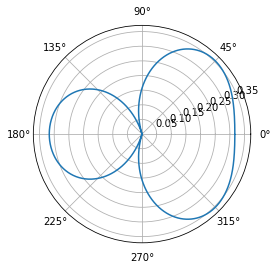

In [41]:
from Source.misc_fun.utils import plotbeam
from Source.antenna import ula

wRF = ula.steervec(2, 45*np.pi/180, 0)
print(wRF)
#wRF= ula.steervec(16,45*np.pi/180, 0)

print(wRF)
#wRF = wRF[::2]
temp = np.zeros(16, dtype=np.complex)
temp[:2] =wRF
wRF = temp
#wRF[1::2] = temp
print(wRF)

wh = wRF.T.conj()
r = np.arange(0, 1, 0.001)
theta = 2* np.pi * r
gr = np.abs(np.array([wh.dot(ula.steervec(16, x, 0)) for x in theta]))#ula.steervec(n, x, 0)

fig = plt.figure()
ax = plt.subplot(111, projection='polar')
ax.plot(theta, gr)
plt.show()

In [12]:
#Testing the max possible reward
from Source.antenna import ula
from Source.misc_fun.geometry import *
from Source.misc_fun.conversion import *


sc = np.array([])
tx_loc = np.array([[100,0,0]])
tbdir_ndx = 3

ch_randval = np.exp(1j * 2 * np.pi * 0.6)
obs = env.test_reset(tx_loc, tbdir_ndx, sc,ch_randval)

print("tx_loc: {}, tx_bdir: {}".format(env.tx_loc, env.tx_bdir*(180/np.pi)))

tx = env.tx_loc
rx = env.rx_loc
(az_aoa, el_aoa, temp) = cart2sph(tx[0, 0] - rx[0, 0], tx[0, 1] -rx[0, 1], tx[0, 2] - rx[0, 2])

wRF = ula.steervec(env.N_rx, az_aoa, el_aoa)
rssi_val = np.sqrt(env.N_rx * env.N_tx) * np.array(np.conj(wRF.T).dot(env.h[:, :, 0])).dot(env.tx_beam) #+ (np.conj(wRF.T).dot(env.noise))[0]

Es = db2lin(env.P_tx)  # * (1e-3 / self.B)
SNR = Es * np.abs(rssi_val) ** 2 / (env.N0 * env.B)
rate = np.log2(1 + SNR)  # in Gbit/s (self.B / self.nFFT) *

print(rssi_val)
print("rate: ", rate)
min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,_,_ = env.get_minmax_exhrate(ch_randval)
print("min exh rate: {}, min action ndx: {}".format(min_exh_rate, min_action_ndx))
print("max exhx rate: {}, max action ndx: {}".format(max_exh_rate, max_action_ndx))
#eff_ch = np.array(env.h[: , :,0]).dot(env.tx_beam)
#print(eff_ch)
#print(eff_ch.real.ravel())
#print(eff_ch.imag.ravel())

#As the max reward is close to 1, calculation of reward based on reward seems to be good, 
#especially with random tx_beam and additional noise

tx_loc: [[100   0   0]], tx_bdir: 90.0
(2.9150843384912097e-21+1.9263255079886912e-21j)
rate:  0.0
min exh rate: 0.0, min action ndx: 0
max exhx rate: 0.0, max action ndx: 0


In [5]:
obs = env.reset()
#print(obs)
print("cap: ", env.get_capacity())
print("TX loc: ", env.tx_loc)
i=0
while True:
    action = env.action_space.sample()
    obs, rwd, done, _ = env.step(action)
    #if (i==0):
    #    print(obs)
    #    i+=1
    print(action, rwd, env.rate)
    
    if done:
        break

cap:  63.20122720374464
TX loc:  [[5 5 0]]
1 1.0 24.921197795269865
7 0.0 19.474026682266594
2 0.0 19.784164261454205
2 0.0 19.784164261454205
7 0.0 19.474026682266594
4 0.0 18.9690924079018
6 0.0 20.688128360888456
5 0.0 19.343283062822444
7 0.0 19.474026682266594


In [24]:
sc = np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0]])
obs = env.test_reset(np.array([[100,0,0]]), 2, sc)
print(env.tx_loc)
print(env.tx_bdir*(180/np.pi))
print(env.rx_bdir*(180/np.pi))
rate, ndx, rssi_val = env.get_exh_rate()
print(rssi_val)
print(rate)
print(env.channel.pathloss)

[[100   0   0]]
67.5
180.0
(5.641096401206994e-07+2.563267528998267e-06j)
14.815773595650851
[113.14242509 125.77402271 119.32562882 119.60381232 122.47205674]


In [25]:
tx_loc = np.array([[100,0,0]])
sc = np.array([[0,100,0]])

best_rssi_val = 0
best_rate = 0.0
best_rx_ndx = 0
best_tx_ndx = 0
for tx_ndx in range(env.N_tx):
    obs = env.test_reset(tx_loc, tx_ndx, sc)
    rate, rx_ndx, rssi_val = env.get_exh_rate()
    if (rate > best_rate):
        best_rate = rate
        best_rssi_val = rssi_val
        best_rx_ndx = rx_ndx
        best_tx_ndx = tx_ndx    

print(tx_loc)
print("TX bdir: ", env.BeamSet[best_tx_ndx]*(180/np.pi))
print("RX bdir: ", env.BeamSet[best_rx_ndx]*(180/np.pi))
print(best_rssi_val)
        

[[100   0   0]]
TX bdir:  135.0
RX bdir:  90.0
(-5.444413426840645e-06+1.67561815733637e-05j)


[2.431865088886842e-12, 1.8861809888304007e-11, 4.606373183911933e-13, 5.470063724567657e-12, 2.8795071706361734e-13, 7.160217231213812e-13, 3.2516336004949533e-12, 5.09637369458276e-12]
[7.941604247022229e-13, 5.719816740152456e-13, 3.118106415741736e-13, 2.831572472347899e-13, 1.8474084999567433e-13, 8.694960671060668e-14, 6.430574782661766e-14, 1.663451788014354e-15]
[1, 0, 6, 7, 4, 5, 3, 2]


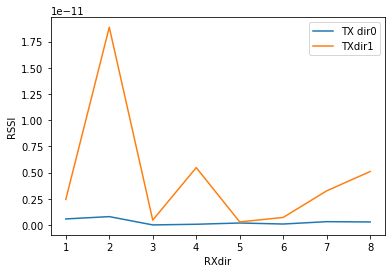

In [9]:
#Plot the curves for RSSI vs rx bdir for two different tx_directions

tx_loc = np.array([[100,50,0]])
sc = np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0], [100,50,0], [80,85,0], [20,30,0], [10,40,0], [80,20,0]])

obs_1 = env.test_reset(tx_loc, 2, sc)
rssi_values1, rate_values1 = env.meas_rate()
rssi_values1 = [np.abs(x) ** 2 for x in rssi_values1]
yaxis1 = list(reversed(np.sort(rssi_values1)))

obs_2 = env.test_reset(tx_loc, 5, sc)
rssi_values2, rate_values2 = env.meas_rate()
rssi_values2 = [np.abs(x) ** 2 for x in rssi_values2]
print(rssi_values2)
yaxis2 = list(reversed(np.sort(rssi_values2)))

fig = plt.figure()
#ax1 = fig.add_subplot(131)
xaxis1 = []
for val in yaxis1:
    ndx = rssi_values1.index(val)
    xaxis1.append(ndx)
    
xaxis2 = []
for val in yaxis2:
    ndx = rssi_values2.index(val)
    xaxis2.append(ndx)

print(yaxis1)
print(xaxis1)

#plt.plot(xaxis1, yaxis1,xaxis2, yaxis2 )
plt.plot(np.arange(1, env.N_tx+1), rssi_values1,np.arange(1, env.N_tx+1), rssi_values2 )

plt.ylabel('RSSI')
plt.xlabel('RXdir')
plt.legend(['TX dir0', 'TXdir1'])
plt.show()


In [ ]:
print(env.BeamSet[])